# Develop `baynes_sound_agrif` Figure Module

Development of functions for `nowcast.figures.research.baynes_sound_agrif` web site figure module.

**Goal:** A 4 panel figures showing  surface values of
temperature, salinity, diatoms biomass, and nitrate concentration
at 12:30 Pacific time.
Each panel to show all of the Baynes Sound sub-grid as well as
a fringe of the full domain on the 3 non-land sides.
Ideally the axes tick labels will be lon/lat with angled grid lines.

In [1]:
from pathlib import Path
import sys
from types import SimpleNamespace

import arrow
import cartopy
import cmocean
import matplotlib.pyplot as plt
import numpy
import xarray

from nowcast.figures import shared
import nowcast.figures.website_theme

/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/tidetools.py:1569: SyntaxWarning: invalid escape sequence '\*'
  """Function for the fit, assuming only 4 constituents of importance are:
/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/tidetools.py:1608: SyntaxWarning: invalid escape sequence '\*'
  """Function for the fit, assuming 6 constituents of importance are:
/media/doug/warehouse/MEOPAR/tools/SalishSeaTools/salishsea_tools/tidetools.py:1653: SyntaxWarning: invalid escape sequence '\*'
  """Function for the fit, for all the constituents: M2, K2, S1, O1, N2, P1,


Python and library versions:

In [2]:
import bottleneck
import h5netcdf
import h5py
import matplotlib

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC 12.4.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
matplotlib.__version__='3.9.2'
cmocean.__version__='v3.0.3'


## `_prep_plot_data()` Function

In [3]:
def _prep_plot_data(ss_tracers_path, bs_phys_path, bs_bio_path, run_date, ss_grid_path,
                    bs_grid_path):
    """
    :type ss_tracers_path: :py:class:`pathlib.Path`
    :type bs_phys_path: :py:class:`pathlib.Path`
    :type bs_bio_path: :py:class:`pathlib.Path`
    :type run_date: :py:class:`arrow.Arrow`
    :type ss_grid_path: :py:class:`pathlib.Path`
    :type bs_grid_path: :py:class:`pathlib.Path`

    :rtype: :py:class:`types.SimpleNamespace`
    """
    # SS_BAYNES_SOUND_X, SS_BAYNES_SOUND_Y = slice(112, 166), slice(550, 699)
    SS_BAYNES_SOUND_X, SS_BAYNES_SOUND_Y = slice(111, 166), slice(549, 699)
    ss_grid = xarray.open_dataset(ss_grid_path, mask_and_scale=False, engine="h5netcdf").sel(
        x=SS_BAYNES_SOUND_X, y=SS_BAYNES_SOUND_Y
    )
    ss_water_mask = numpy.array(ss_grid.Bathymetry != 0)
    bs_grid = xarray.open_dataset(bs_grid_path, mask_and_scale=False, engine="h5netcdf")
    bs_water_mask = numpy.array(bs_grid.Bathymetry != 0)

    ss_tracers = xarray.open_dataset(ss_tracers_path, engine="h5netcdf")
    shared.localize_time(ss_tracers, time_coord="time_counter")

    bs_phys = xarray.open_dataset(bs_phys_path, engine="h5netcdf")
    bs_bio = xarray.open_dataset(bs_bio_path, engine="h5netcdf")
    for dataset in (bs_phys, bs_bio):
        shared.localize_time(dataset, time_coord="time_counter")

    ss_temperature = _get_data_array(ss_tracers.votemper, ss_water_mask, run_date)
    bs_temperature = _get_data_array(bs_phys.votemper, bs_water_mask, run_date)
    bs_temperature.attrs["long_name"] = "Conservative Temperature"
    ss_salinity = _get_data_array(ss_tracers.vosaline, ss_water_mask, run_date)
    bs_salinity = _get_data_array(bs_phys.vosaline, bs_water_mask, run_date)
    bs_salinity.attrs["long_name"] = "Reference Salinity"
    ss_diatoms = _get_data_array(ss_tracers.diatoms, ss_water_mask, run_date)
    bs_diatoms = _get_data_array(bs_bio.diatoms, bs_water_mask, run_date)
    ss_nitrate = _get_data_array(ss_tracers.nitrate, ss_water_mask, run_date)
    bs_nitrate = _get_data_array(bs_bio.nitrate, bs_water_mask, run_date)
    return SimpleNamespace(
        ss_temperature=ss_temperature,
        bs_temperature=bs_temperature,
        ss_salinity=ss_salinity,
        bs_salinity=bs_salinity,
        ss_diatoms=ss_diatoms,
        bs_diatoms=bs_diatoms,
        ss_nitrate=ss_nitrate,
        bs_nitrate=bs_nitrate,
        run_date=run_date,
        tz_name=bs_phys.attrs["tz_name"],
        ss_grid=ss_grid,
        bs_grid=bs_grid,
    )


In [4]:
def _get_data_array(ds_var, water_mask, run_date):
    """
    :type ds_var: :py:class:`xarray.DataArray`
    :type water_mask: :py:class:`numpy.ndarray`
    :type run_date: :py:class:`arrow.Arrow`

    :rtype: :py:class:`xarray.DataArray`
    """
    try:
        return (
            ds_var.isel(nearsurface_T=0)
            .sel(time_counter=run_date.format("YYYY-MM-DD 12:30"))
            .where(water_mask)
        )
    except ValueError:
        return (
            ds_var.isel(deptht=0)
            .sel(time_counter=run_date.format("YYYY-MM-DD 12:30"))
            .where(water_mask)
        )

## `_prep_fig_axes()` Function

In [5]:
def _prep_fig_axes(figsize, plot_data, theme):
    """
    :type figsize: 2-tuple
    :type plot_data: :py:class:`types.SimpleNamespace`
    :type theme: :py:mod:`nowcast.figures.website_theme`

    :rtype: :py:class:`matplotlib.figure.Figure`,
            4-tuple of :py:class:`matplotlib.axes.Axes`
    """
    rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
    fig, axs = plt.subplots(
        1,
        4,
        figsize=figsize,
        facecolor=theme.COLOURS["figure"]["facecolor"],
        subplot_kw={"projection": rotated_crs, "facecolor": theme.COLOURS["dark land"]},
    )
    return fig, axs


## `_plot_surface_fields()` Function

In [6]:
def _plot_surface_fields(axs, plot_data, theme):
    """
    :type axs: 4-tuple of :py:class:`matplotlib.axes.Axes`
    :type plot_data: :py:class:`types.SimpleNamespace`
    :type theme: :py:mod:`nowcast.figures.website_theme`
    """
    vars = [
        (plot_data.ss_temperature, plot_data.bs_temperature, cmocean.cm.thermal),
        (plot_data.ss_salinity, plot_data.bs_salinity, cmocean.cm.haline),
        (plot_data.ss_diatoms, plot_data.bs_diatoms, cmocean.cm.algae),
        (plot_data.ss_nitrate, plot_data.bs_nitrate, cmocean.cm.matter),
    ]
    for i, (ss_var, bs_var, cmap) in enumerate(vars):
        _plot_surface_field(
            axs[i], ss_var, bs_var, cmap, plot_data.ss_grid, plot_data.bs_grid, theme
        )

In [7]:
def _plot_surface_field(ax, ss_var, bs_var, cmap, ss_grid, bs_grid, theme):
    """
    :type ax: :py:class:`matplotlib.axes.Axes`
    :type ss_var: :py:class:`xarray.DataArray`
    :type bs_var: :py:class:`xarray.DataArray`
    :type cmap: :py:class:`matplotlib.colors.ListedColormap`
    :type ss_grid: :py:class:`xarray.DataArray`
    :type bs_grid: :py:class:`xarray.DataArray`
    :type theme: :py:mod:`nowcast.figures.website_theme`
    """
    plain_crs = cartopy.crs.PlateCarree()
    clevels = numpy.linspace(
        numpy.floor(bs_var.where(bs_var > 0).min()),
        numpy.ceil(bs_var.where(bs_var > 0).max()),
        20,
    )
    ax.contourf(
        ss_grid.nav_lon,
        ss_grid.nav_lat,
        ss_var,
        transform=plain_crs,
        cmap=cmap,
        levels=clevels,
        extend="max",
    )
    map_extent = ax.get_extent()
    contour_set = ax.contourf(
        bs_grid.nav_lon,
        bs_grid.nav_lat,
        bs_var,
        transform=plain_crs,
        cmap=cmap,
        levels=clevels,
        extend="max",
    )
    ax.set_extent(map_extent, crs=ax.projection)
    cbar = plt.colorbar(contour_set, ax=ax)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS["cbar"]["tick labels"])
    cbar.set_label(
        f'{bs_var.attrs["long_name"]} [{bs_var.attrs["units"]}]',
        color=theme.COLOURS["text"]["axis"],
        fontproperties=theme.FONTS["axis"],
    )
    isobath = ax.contour(
        bs_grid.nav_lon,
        bs_grid.nav_lat,
        bs_grid.Bathymetry,
        (25,),
        transform=plain_crs,
        colors=theme.COLOURS["contour lines"]["Baynes Sound entrance"],
    )
    ax.clabel(isobath, fmt={isobath.levels[0]: f"{isobath.levels[0]:.0f} m"})

## `_axes_labels()` Function

In [8]:
def _axes_labels(axs, theme):
    """
    :type axs: 4-tuple of :py:class:`matplotlib.axes.Axes`
    :type theme: :py:mod:`nowcast.figures.website_theme`
    """
    for ax in axs:
        glines = ax.gridlines(draw_labels=True, auto_inline=False)
        glines.right_labels, glines.top_labels = False, False
        glines.xlabel_style = {
            "color": theme.COLOURS["text"]["axis"],
            "fontproperties": theme.FONTS["axis small"],
        }
        glines.ylabel_style = {
            "color": theme.COLOURS["text"]["axis"],
            "fontproperties": theme.FONTS["axis small"],
        }

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [9]:
def make_figure(ss_tracers_path, bs_phys_path, bs_bio_path, run_date, ss_grid_path, bs_grid_path,
                figsize=(22, 9), theme=nowcast.figures.website_theme):
    """Plot a 4-panel figure that shows surface values of temperature, salinity,
    diatom biomass, and nitrate concentration in the Baynes Sound region at
    12:30 Pacific time.
    Each panel shows the whole Baynes Sound sub-grid
    as well as a fringe of the full domain on the 3 non-land sides.
    The axes
    grid and tick labels are an angled lon/lat grid.

    :param ss_tracers_path: File path of full domain hourly physics tracers
                            dataset.
    :type ss_tracers_path: :py:class:`pathlib.Path`

    :param bs_phys_path: File path of Baynes Sound sub-grid hourly physics
                         tracers dataset.
    :type bs_phys_path: :py:class:`pathlib.Path`

    :param bs_bio_path: File path of Baynes Sound sub-grid hourly biology
                        tracers dataset.
    :type bs_bio_path: :py:class:`pathlib.Path`

    :param run_date: Run date to produce the figure for.
    :type :py:class:`arrow.Arrow` run_date:

    :param ss_grid_path: File path of the full domain geolocation and
                         bathymetry dataset that provides longitudes and
                         latitudes of the domain grid, and water depths.
    :type :py:class:`pathlib.Path` ss_grid_path:

    :param bs_grid_path: File path of Baynes Sound sub-grid bathymetry dataset
                         that provides longitudes and latitudes of the
                         sub-grid, and water depths.
    :type :py:class:`pathlib.Path` bs_grid_path:

    :param 2-tuple figsize: Figure size (width, height) in inches.

    :param theme: Module-like object that defines the style elements for the
                  figure.
                  See :py:mod:`nowcast.figures.website_theme` for an
                  example.

    :returns: :py:class:`matplotlib.figure.Figure`
    """
    plot_data = _prep_plot_data(ss_tracers_path, bs_phys_path, bs_bio_path, run_date, ss_grid_path,
                                bs_grid_path)
    fig, axs = _prep_fig_axes(figsize, plot_data, theme)
    _plot_surface_fields(axs, plot_data, theme)
    _axes_labels(axs, theme)

    time = plot_data.bs_temperature.time_counter
    year = time.dt.year.values.item()
    month = time.dt.month.values.item()
    day = time.dt.day.values.item()
    hour = time.dt.hour.values.item()
    minute = time.dt.minute.values.item()
    fig.suptitle(
        f"{year}-{month:02d}-{day:02d} {hour:02d}:{minute:02d} {plot_data.tz_name}",
        color=theme.COLOURS["text"]["figure title"],
        fontproperties=theme.FONTS["figure title"],
        fontsize=theme.FONTS["figure title"].get_size(),
    )
    fig.canvas.draw()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

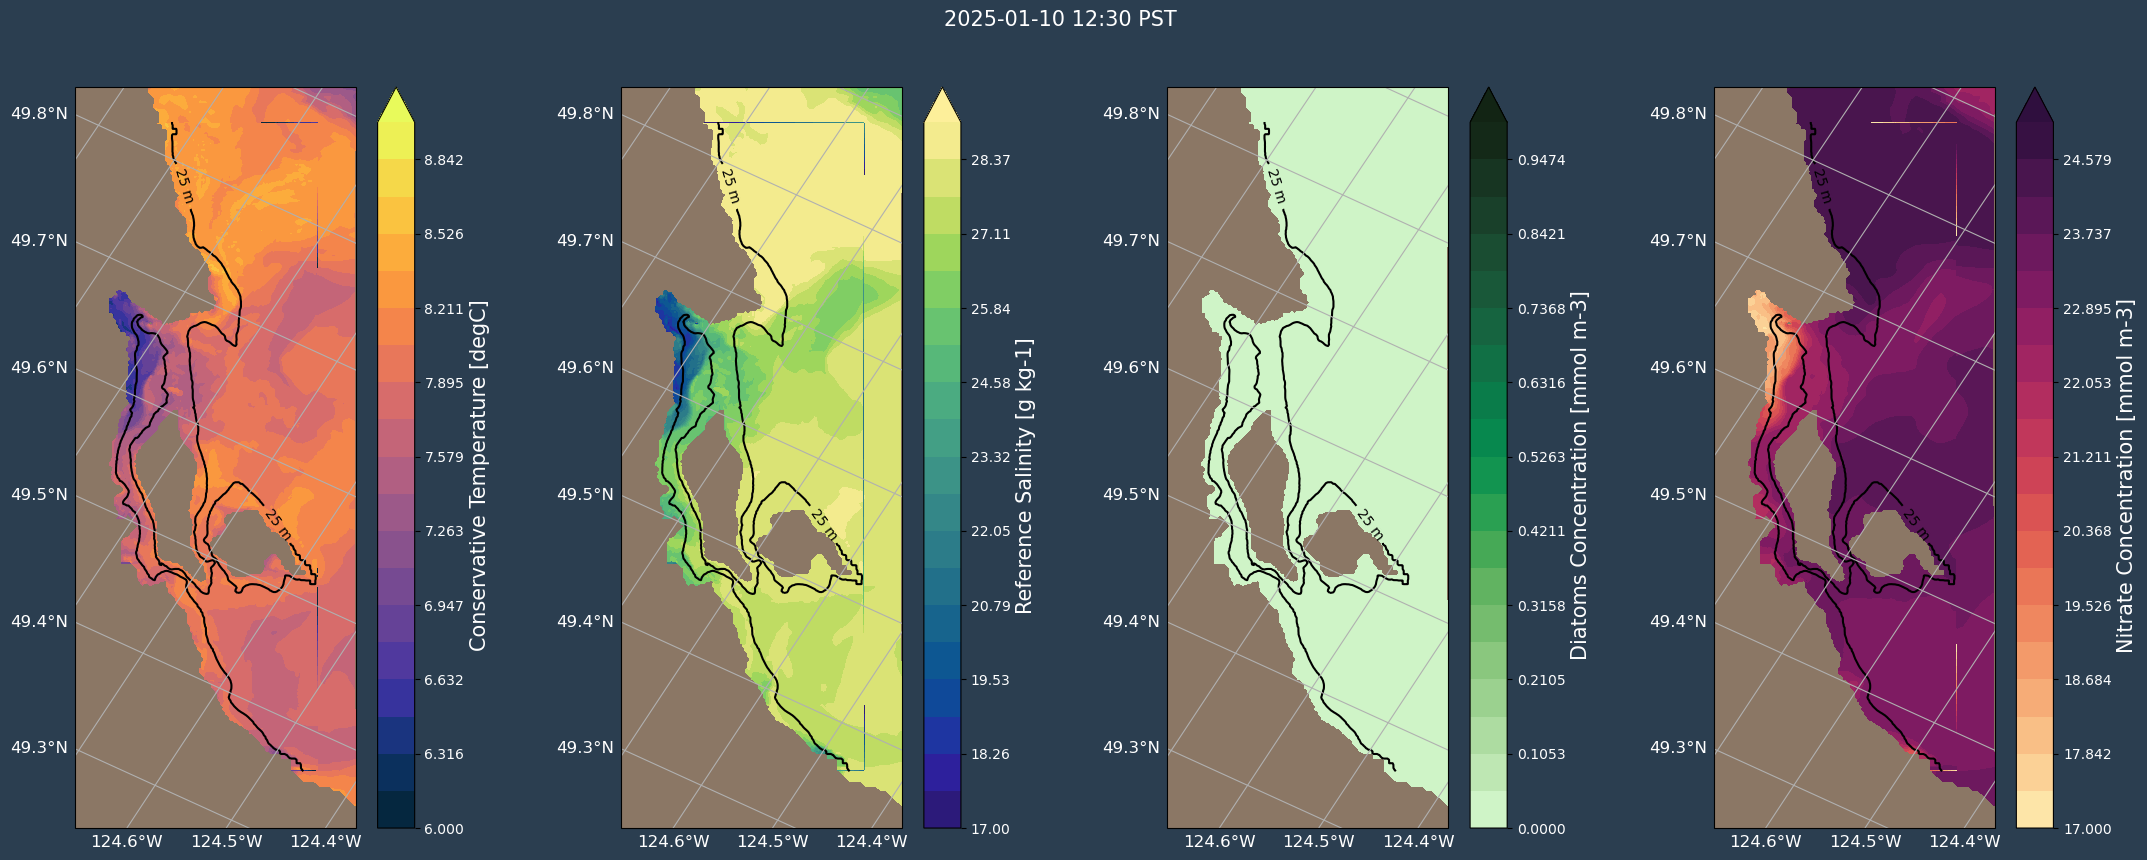

In [10]:
# %%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
reload(website_theme)

agrif_results_archive = Path('/results/SalishSea/nowcast-agrif.201702/')
run_date = arrow.get('2025-01-10')
ddmmmyy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

ss_tracers_path = agrif_results_archive/ddmmmyy/'BaynesSoundSurface_grid_T.nc'
bs_phys_path = agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc'
bs_bio_path = agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc'
ss_grid_path = Path('/media/doug/warehouse/MEOPAR/grid/bathymetry_201702.nc')
bs_grid_path = Path('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc')

fig = make_figure(ss_tracers_path, bs_phys_path, bs_bio_path, run_date, ss_grid_path, bs_grid_path)